In [1]:
import os
import pickle
import torch
import torch.nn.functional as nnf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from torchvision import transforms, datasets
from tqdm import tqdm

import util.util_validation as ut_val

from util.util_logging import open_csv_file
from util.util_diff import DiffLoader, DiffTransform
from util.util_diff import SameTwoColorJitter, SameTwoApply

seaborn.set_style("darkgrid")

In [2]:
models_dict = {"CE_baseline": ["./save/SupCE/animals10/SupCE_animals10_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_baseline_cosine/models/last.pth", None],
               "CE_origAllAug": ["./save/SupCE/animals10_diff_-1/SupCE_animals10_diff_-1_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_origAllAug_cosine/models/last.pth", None],
               "CE_diff4000": ["./save/SupCE/animals10_diff_4000/SupCE_animals10_diff_4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000_cosine/models/last.pth", None],
               "CE_diff4000AllAug": ["./save/SupCE/animals10_diff_4000/SupCE_animals10_diff_4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000AllAug_cosine/models/last.pth", None],
               "CE_diff8000": ["./save/SupCE/animals10_diff_8000/SupCE_animals10_diff_8000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_8000_cosine/models/last.pth", None],
               "CE_diffAug": ["./save/SupCE/animals10_diff_-1+4000/SupCE_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_diffAug_cosine/models/last.pth", None],
               "CE_diffAugAllAug": ["./save/SupCE/animals10_diff_-1+4000/SupCE_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_diffAugAllAug_cosine/models/last.pth", None],
               "SupCon_baseline": ["./save/SupCon/animals10_diff_-1/SupCon_animals10_diff_-1_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_try3_cosine/models/last.pth", ""],
               "SupCon_diff4000NoAug": ["./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth", ""],
               "SupCon_diffCSameSAug": ["./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAugSameShapeAug_cosine/models/last.pth", ""],
               "SupCon_diffAllSameAug": ["./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_allSameAug_cosine/models/last.pth", ""],
               "SupConHybrid_diffNoAug": ["./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth", ""],
               "SupConHybrid_diffColorAug": ["./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAug_cosine/models/last.pth", ""],
               "SupConFactor_factor5cAugSameSAug": ["./save/SupCon/animals10_diff_-1+4000/SupCon_5.0_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_factor5cAugSameSAug_cosine/models/last.pth", ""]}

# models_dict = {"CE_city": ["./save/SupCE/city_classification_original/SupCE_city_classification_original_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_cityBaseline_cosine/models/last.pth", None],
#                "CE_cityDiff": ["./save/SupCE/city_classification_diff/SupCE_city_classification_diff_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_cityDiff_cosine/models/last.pth", None]}

In [3]:
models_dict = {"CE_origAllAug": ["./save/SupCE/animals10_diff_-1/SupCE_animals10_diff_-1_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_origAllAug_cosine/models/last.pth", None],
               "CE_diff4000AllAug": ["./save/SupCE/animals10_diff_4000/SupCE_animals10_diff_4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000AllAug_cosine/models/last.pth", None],
               "CE_diffAugAllAug": ["./save/SupCE/animals10_diff_-1+4000/SupCE_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_diffAugAllAug_cosine/models/last.pth", None],
               "SupCon_baseline": ["./save/SupCon/animals10_diff_-1/SupCon_animals10_diff_-1_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_try3_cosine/models/last.pth", ""],
               "SupCon_diffCSameSAug": ["./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAugSameShapeAug_cosine/models/last.pth", ""],
               "SupConHybrid_diffColorAug": ["./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAug_cosine/models/last.pth", ""],
               "SupConFactor_factor5cAugSameSAug": ["./save/SupCon/animals10_diff_-1+4000/SupCon_5.0_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_factor5cAugSameSAug_cosine/models/last.pth", ""]}

In [4]:
cuda_device = 1

root_dataset_conflict = "./datasets/adaIN/shape_texture_conflict_animals10_many/"
# root_dataset_conflict = "./datasets/adaIN/shape_texture_conflict_animals10_two/"

dataset_orig = "animals10_diff_-1"
dataset_shape = "animals10_diff_4000"

## Functions

### Cue Conflict Shape Bias

In [5]:
def evaluate_cue_conflict_dataset(root_model, dataset_classifier, root_dataset_conflict, cuda_device, exclude_original_dict=dict()):
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))
    if dataset_classifier is None:
        path_classifier = ut_val.get_path_classifier(root_model, "", params)
    else:
        path_classifier = ut_val.get_path_classifier(root_model, dataset_classifier, params)

    normalize = transforms.Normalize(mean=params["mean"], std=params["std"])
    val_transform = transforms.Compose([transforms.Resize(params["size"]), transforms.CenterCrop(params["size"]), transforms.ToTensor(), normalize])

    conflict_dataset = ut_val.shapeTextureConflictDataset(root_dataset_conflict, val_transform, exclude_original_dict)
    classes = conflict_dataset.classes

    conflict_dataloader = torch.utils.data.DataLoader(conflict_dataset, batch_size=params["batch_size"],
                                                      shuffle=False, num_workers=params["num_workers"], pin_memory=True)

    model = ut_val.set_model(root_model, params, cuda_device)
    if path_classifier:
        classifier = ut_val.load_classifier_checkpoint(path_classifier, params["model"], len(classes), cuda_device)
    else:
        assert "num_classes" in params
        classifier = model.fc
    
    df_pred = ut_val.shape_texture_predictions(model, classifier, conflict_dataloader, cuda_device)

    return df_pred, classes

In [6]:
def evaluate_cue_conflict_dataset_for_many(models_dict, root_dataset_conflict, cuda_device, exclude_original_dict=dict()):
    print("Get predictions for shape texture cue conflict dataset")
    pred_dict = dict()

    for m in models_dict:
        root_model, dataset_classifier = models_dict[m]

        df_pred, classes = evaluate_cue_conflict_dataset(root_model, dataset_classifier, root_dataset_conflict, cuda_device, exclude_original_dict)
        pred_dict[m] = df_pred

    return pred_dict, classes

In [7]:
def compute_cue_conflict_shape_bias_metric(df_pred, classes, model_short_name, shape="shape_class", texture="texture_class", pred="pred_class"):
    class_bias_dict = dict()

    for l,c in enumerate(classes):
        # number of shape/texture images for the class ("positive")
        total_class_shape = len(df_pred.query(f"{shape}=={l}"))
        total_class_texture = len(df_pred.query(f"{texture}=={l}"))
        total_class = total_class_shape + total_class_texture
        # number of correct shape/texture predictions for the class ("true positive")
        true_class_shape = len(df_pred.query(f"{shape}=={l} and {pred}=={l}"))
        true_class_texture = len(df_pred.query(f"{texture}=={l} and {pred}=={l}"))
        true_class = true_class_shape + true_class_texture

        # compute class shape bias ["true positive shape" / ("true positive shape" + "true positive texture")]
        if true_class_shape + true_class_texture != 0.0:
            c_s_bias = true_class_shape / (true_class_shape + true_class_texture)
        else:
            c_s_bias = np.nan

        # compute class recall ["true positive" / "positive"]
        c_recall_shape = true_class_shape / total_class_shape
        c_recall_texture = true_class_texture / total_class_texture
        c_recall = true_class / total_class
        c_recall_b = (c_recall_shape + c_recall_texture) / 2

        # compute balanced class shape bias ["recall shape" / ("recall shape" + "recall texture")]
        if c_recall_shape + c_recall_texture != 0.0:
            c_s_bias_b = c_recall_shape / (c_recall_shape + c_recall_texture)
        else:
            c_s_bias_b = np.nan

        class_bias_dict[c] = {"shape_bias": c_s_bias, "shape_bias_b": c_s_bias_b,
                              "recall": c_recall, "recall_b": c_recall_b, "recall_shape": c_recall_shape, "recall_texture": c_recall_texture}
    df_class_bias= pd.DataFrame(class_bias_dict)

    # shape bias and accuracies
    shape_bias, acc, acc_shape, acc_texture = ut_val.shape_texture_conflict_bias(df_pred=df_pred, shape=shape, texture=texture, pred=pred)

    # balanced shape bias and balanced accuracies
    acc_b_shape, acc_b_texture = df_class_bias.loc[["recall_shape", "recall_texture"]].mean(axis=1).values
    acc_b =  acc_b_shape + acc_b_texture
    if acc_b != 0.0:
        shape_bias_b = acc_b_shape / acc_b
    else:
        shape_bias_b = np.nan

    df_bias = pd.DataFrame.from_dict({"shape_bias": shape_bias, "shape_bias_b": shape_bias_b,
                                      "acc": acc, "acc_b": acc_b,
                                      "acc_shape": acc_shape, "acc_b_shape": acc_b_shape,
                                      "acc_texture": acc_texture, "acc_b_texture": acc_b_texture},
                                     orient="index", columns=[model_short_name])

    return df_bias, df_class_bias

In [8]:
def compute_cue_conflict_shape_bias_metric_for_many(pred_dict, classes, shape="shape_class", texture="texture_class", pred="pred_class"):
    bias_list = []
    class_biasses = dict()

    for m in pred_dict:
        df_bias, df_class_bias = compute_cue_conflict_shape_bias_metric(pred_dict[m], classes, m, shape, texture, pred)

        bias_list.append(df_bias)
        class_biasses[m] = df_class_bias

    df_biases = pd.concat(bias_list, axis=1)

    return df_biases, class_biasses

In [9]:
def cue_conflict_shape_bias_metric(root_model, dataset_classifier, model_short_name, root_dataset_conflict, cuda_device):
    df_pred, classes = evaluate_cue_conflict_dataset(root_model, dataset_classifier, root_dataset_conflict, cuda_device)
    df_bias, df_class_bias = compute_cue_conflict_shape_bias_metric(df_pred, classes, model_short_name)

    return df_bias, df_class_bias

In [10]:
def cue_conflict_shape_bias_metric_for_many(models_dict, root_dataset_conflict, cuda_device):
    pred_dict, classes = evaluate_cue_conflict_dataset_for_many(models_dict, root_dataset_conflict, cuda_device)
    df_biases, class_biasses = compute_cue_conflict_shape_bias_metric_for_many(pred_dict, classes)

    return df_biases, class_biasses

### Correlation Coefficient Shape Bias

In [11]:
from typing import Any


class ShufflePatches:
    # inspired from https://stackoverflow.com/questions/66962837/shuffle-patches-in-image-batch
    def __init__(self, patch_size):
        self.patch_size = patch_size

    def __call__(self, x):
        # unfold the tensor image
        u = nnf.unfold(x, kernel_size=self.patch_size , stride=self.patch_size , padding=0)
        # shuffle the patches in unfolded form
        pu = u[:,torch.randperm(u.shape[-1])]
        # fold the tensor back in its original form
        f = nnf.fold(pu, x.shape[-2:], kernel_size=self.patch_size, stride=self.patch_size, padding=0)

        return f
    
    def apply_to_batch(self, x):
        # unfold the tensor image
        u = nnf.unfold(x, kernel_size=self.patch_size , stride=self.patch_size , padding=0)
        # shuffle the patches in unfolded form
        pu = torch.stack([b_[:,torch.randperm(b_.shape[-1])] for b_ in u], dim=0)
        # fold the tensor back in its original form
        f = nnf.fold(pu, x.shape[-2:], kernel_size=self.patch_size, stride=self.patch_size, padding=0)

        return f
    

class TwoDifferentApply:

    def __init__(self, transform_orig=None, transform_diff=None):
        self.transform_orig = transform_orig
        self.transform_diff = transform_diff

    def __call__(self, x):
        x_orig, x_diff = x

        if self.transform_orig:
            x_orig = self.transform_orig(x_orig)
        if self.transform_diff:
            x_diff = self.transform_diff(x_diff)

        return [x_orig, x_diff]

In [12]:
def compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, use_colorJitter=False, patch_size=30):
    path_folder, path_embeddings_orig, path_embeddings_diff, _ = ut_val.get_paths_from_model_checkpoint(root_model, dataset_1=dataset_orig, dataset_2=dataset_shape)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    _, root_dataset_orig = ut_val.get_root_dataset(dataset=dataset_orig)

    # compute patch shuffled embeddings of the original dataset to keep texture information but remove shape information
    normalize = transforms.Normalize(mean=params['mean'], std=params['std'])
    shufflePatchers_transform_list = []
    if use_colorJitter:
        shufflePatchers_transform_list.append(transforms.ColorJitter(0.4, 0.4, 0.4, 0.4))
    shufflePatchers_transform_list.extend([transforms.ToTensor(), ShufflePatches(patch_size=patch_size), normalize])
    shufflePatchers_transform = transforms.Compose(shufflePatchers_transform_list)

    shufflePatches_dataset = datasets.ImageFolder(root=root_dataset_orig,transform=shufflePatchers_transform)
    shufflePatches_dataloader = torch.utils.data.DataLoader(shufflePatches_dataset, batch_size=params['batch_size'],
                                                            shuffle=False, num_workers=16, pin_memory=True)

    model = ut_val.set_model(root_model, params, cuda_device)

    embedding_texture, _ = ut_val.compute_embedding(model, shufflePatches_dataloader, params, cuda_device)

    # load the pre computed original embeddings
    with open(os.path.join(path_embeddings_orig, "embedding_test"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_orig = entry['data']
        class_labels = entry['labels']

    if use_colorJitter:
        # compute the color jittered embeddings of the shape dataset
        _, root_dataset_shape = ut_val.get_root_dataset(dataset=dataset_shape)

        shape_transform = transforms.Compose([transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
                                              transforms.ToTensor(), normalize])
        
        shape_dataset = datasets.ImageFolder(root=root_dataset_shape,transform=shape_transform)
        shape_dataloader = torch.utils.data.DataLoader(shape_dataset, batch_size=params['batch_size'],
                                                       shuffle=False, num_workers=16, pin_memory=True)
        
        embedding_shape, _ = ut_val.compute_embedding(model, shape_dataloader, params, cuda_device)
    else:
        # load pre computed embeddings of the shape dataset
        with open(os.path.join(path_embeddings_diff, "embedding_test"), 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            embedding_shape = entry['data']

    return embedding_orig, embedding_shape, embedding_texture, class_labels

In [13]:
def compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, use_colorJitter=False, patch_size=30):
    path_folder, path_embeddings_orig, path_embeddings_diff, _ = ut_val.get_paths_from_model_checkpoint(root_model, dataset_1=dataset_orig, dataset_2=dataset_shape)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    _, root_dataset_orig = ut_val.get_root_dataset(dataset=dataset_orig)

    # load the pre computed original embeddings
    with open(os.path.join(path_embeddings_orig, "embedding_test"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_orig = entry['data']
        class_labels = entry['labels']

    if use_colorJitter:
        # compute the embeddings of the shape dataset and the patch shuffled original dataset with the same color jitter applied to both
        _, root_dataset_shape = ut_val.get_root_dataset(dataset=dataset_shape)

        normalize = transforms.Normalize(mean=params['mean'], std=params['std'])
        sameJitterOrigPatchShuffle_transform = transforms.Compose([SameTwoColorJitter(0.4, 0.4, 0.4, 0.4), SameTwoApply(transforms.ToTensor()),
                                                                   TwoDifferentApply(transform_orig=ShufflePatches(patch_size=patch_size))])
        
        textureShape_dataset = datasets.ImageFolder(root=root_dataset_orig,
                                                    loader=DiffLoader(path_orig=root_dataset_orig, path_diff=root_dataset_shape),
                                                    transform=DiffTransform(normalize, sameJitterOrigPatchShuffle_transform))
        textureShape_dataloader = torch.utils.data.DataLoader(textureShape_dataset, batch_size=params['batch_size'],
                                                                shuffle=False, num_workers=params["num_workers"], pin_memory=True)
        
        model = ut_val.set_model(root_model, params, cuda_device)

        embedding_texture, embedding_shape, _ = ut_val.compute_diff_embeddings(model, textureShape_dataloader, params, cuda_device)
        
    else:
        # load pre computed embeddings of the shape dataset
        with open(os.path.join(path_embeddings_diff, "embedding_test"), 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            embedding_shape = entry['data']

        # compute patch shuffled embeddings of the original dataset to keep texture information but remove shape information
        normalize = transforms.Normalize(mean=params['mean'], std=params['std'])
        shufflePatchers_transform = transforms.Compose([transforms.ToTensor(), ShufflePatches(patch_size=patch_size), normalize])

        shufflePatches_dataset = datasets.ImageFolder(root=root_dataset_orig,transform=shufflePatchers_transform)
        shufflePatches_dataloader = torch.utils.data.DataLoader(shufflePatches_dataset, batch_size=params['batch_size'],
                                                                shuffle=False, num_workers=params["num_workers"], pin_memory=True)

        model = ut_val.set_model(root_model, params, cuda_device)

        embedding_texture, _ = ut_val.compute_embedding(model, shufflePatches_dataloader, params, cuda_device)

    return embedding_orig, embedding_shape, embedding_texture, class_labels

In [14]:
def compute_dim_correlation_coefficients(embedding_A, embedding_B):
    A = torch.tensor(embedding_A)
    B = torch.tensor(embedding_B)

    A_dm = A - A.mean(dim=0)
    B_dm = B - B.mean(dim=0)

    correlation = (A_dm * B_dm).sum(dim=0) / ((A_dm * A_dm).sum(dim=0) * (B_dm * B_dm).sum(dim=0)).sqrt()
    correlation = torch.nan_to_num(correlation, nan=0.0)

    return correlation.numpy()

def estimate_dims(correlation):
    correlation_scores = np.mean(np.array(correlation), axis=1)

    scores = np.array(np.concatenate((correlation_scores, [1.0])))

    m = np.max(scores)
    e = np.exp(scores-m)
    softmaxed = e / np.sum(e)

    dim = len(correlation[0])
    dims = [int(s*dim) for s in softmaxed]
    dims[-1] = dim - sum(dims[:-1])

    return dims

In [15]:
def compute_corelation_coefficient_shape_bias_metric(embedding_orig, embedding_shape, embedding_texture, model_short_name):
    corr_coef_shape = compute_dim_correlation_coefficients(embedding_orig, embedding_shape)
    corr_coef_texture = compute_dim_correlation_coefficients(embedding_orig, embedding_texture)
    corr_coef_color = compute_dim_correlation_coefficients(embedding_shape, embedding_texture)

    dims = estimate_dims([corr_coef_shape, corr_coef_texture, corr_coef_color])

    df_dims = pd.DataFrame.from_dict({model_short_name: dims}, orient="index", columns=["shape_dims", "texture_dims", "color_dims", "remaining_dims"])

    return df_dims

In [16]:
def corelation_coefficient_shape_bias_metric(root_model, model_short_name, dataset_orig, dataset_shape, cuda_device, use_colorJitter=False, patch_size=30):
    embedding_orig, embedding_shape, embedding_texture, _ = compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, use_colorJitter, patch_size)

    df_dims = compute_corelation_coefficient_shape_bias_metric(embedding_orig, embedding_shape, embedding_texture, model_short_name)

    return df_dims

In [17]:
def corelation_coefficient_shape_bias_metric_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, use_colorJitter=False, patch_size=30):
    dims_list = []
    for m in models_dict:
        root_model, _ = models_dict[m]

        embedding_orig, embedding_shape, embedding_texture, _ = compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, use_colorJitter, patch_size)

        df_dims = compute_corelation_coefficient_shape_bias_metric(embedding_orig, embedding_shape, embedding_texture, m)
        dims_list.append(df_dims)

    return pd.concat(dims_list, axis=0)

### Feature Embedding Distances

In [18]:
def load_compute_orig_diff_embeddings(root_model, dataset_orig, dataset_diff, cuda_device, aug_dict=None):
    path_folder, path_embeddings_orig, path_embeddings_diff, _ = ut_val.get_paths_from_model_checkpoint(root_model, dataset_1=dataset_orig, dataset_2=dataset_shape)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    if aug_dict:
        # compute original and diffused embeddings with data augmentations from aug_dict
        root_dataset_train_orig, root_dataset_test_orig = ut_val.get_root_dataset(dataset=dataset_orig)
        root_dataset_train_diff, root_dataset_test_diff = ut_val.get_root_dataset(dataset=dataset_diff)

        _, val_loader = ut_val.set_dataloader("", params, root_dataset_train_orig, root_dataset_test_orig, root_dataset_train_diff, root_dataset_test_diff, aug_dict)

        model = ut_val.set_model(root_model, params, cuda_device)

        embedding_orig, embedding_diff, class_labels = ut_val.compute_diff_embeddings(model, val_loader, params, cuda_device)
    else:
        # load pre computed original and diffused embeddings
        with open(os.path.join(path_embeddings_orig, "embedding_test"), 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            embedding_orig = entry['data']
            class_labels = entry['labels']

        with open(os.path.join(path_embeddings_diff, "embedding_test"), 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            embedding_diff = entry['data']

    return embedding_orig, embedding_diff, class_labels

In [19]:
def compute_distance_mean_std(embedding_orig, embedding_diff, class_labels, model_short_name):
    # related distances
    distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_orig), torch.tensor(embedding_diff))
    std_distance, mean_distance = torch.std_mean(distances_embeddings)
    mean_distance = mean_distance.item()
    std_distance = std_distance.item()


    # in class distances
    sum_distances_class = 0.0
    count_distances_class = 0
    for l in tqdm(range(len(set(class_labels)))):
        class_indices = np.where(class_labels == l)[0]

        embedding_class_orig = embedding_orig[class_indices]
        embedding_class_diff = embedding_diff[class_indices]

        for s in range(len(class_indices)):
            distances_embeddings_class = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_class_orig), torch.tensor(embedding_class_diff).roll(s, dims=0))
            sum_distances_class += distances_embeddings_class.sum()
            count_distances_class += len(distances_embeddings_class)

    mean_distance_classes = (sum_distances_class / count_distances_class).item()


    sum_dm_distances_class = 0.0
    for l in tqdm(range(len(set(class_labels)))):
        class_indices = np.where(class_labels == l)[0]

        embedding_class_orig = embedding_orig[class_indices]
        embedding_class_diff = embedding_diff[class_indices]

        for s in range(len(class_indices)):
            distances_embeddings_class = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_class_orig), torch.tensor(embedding_class_diff).roll(s, dims=0))
            sum_dm_distances_class += ((distances_embeddings_class - mean_distance_classes)**2).sum()

    std_distance_class = (sum_dm_distances_class / (count_distances_class-1)).sqrt().item()


    # all versus all distances
    sum_distances_all = 0.0
    count_distances_all = 0
    min_distance = np.inf
    max_distance = -np.inf
    for s in tqdm(range(len(class_labels))):
        distances_embeddings_all = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_orig), torch.tensor(embedding_diff).roll(s, dims=0))
        sum_distances_all += distances_embeddings_all.sum()
        count_distances_all += len(distances_embeddings_all)

        min_dist = distances_embeddings_all.min().item()
        max_dist = distances_embeddings_all.max().item()
        if min_dist < min_distance:
            min_distance = min_dist
        if max_dist > max_distance:
            max_distance = max_dist

    mean_distance_all = (sum_distances_all / count_distances_all).item()


    sum_dm_distances_all = 0.0
    for s in tqdm(range(len(class_labels))):
        distances_embeddings_all = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_orig), torch.tensor(embedding_diff).roll(s, dims=0))
        sum_dm_distances_all += ((distances_embeddings_all - mean_distance_all)**2).sum()

    std_distance_all = (sum_dm_distances_all / (count_distances_all-1)).sqrt().item()


    df_dist = pd.DataFrame.from_dict({"mean_distance_related": [mean_distance], "std_distance_related": [std_distance],
                                      "mean_distance_classes": [mean_distance_classes], "std_distance_classes": [std_distance_class],
                                      "mean_distance_all_vs_all": [mean_distance_all], "std_distance_all_vs_all": [std_distance_all],
                                      "min_distance": [min_distance], "max_distance": [max_distance]},
                                      orient="index", columns=[model_short_name])

    return df_dist

In [20]:
def plot_distance_histograms(df_dist, embedding_orig, embedding_diff, class_labels, model_short_name, n_bins=100, ax=None, dataset_orig=None, dataset_diff=None):
    min_distance = df_dist.loc["min_distance", model_short_name]
    max_distance = df_dist.loc["max_distance", model_short_name]

    # related distances
    distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_orig), torch.tensor(embedding_diff))
    hist_related, bin_edges = np.histogram(distances_embeddings, bins=n_bins, range=(min_distance, max_distance))
    hist_related = hist_related.astype(float) / np.sum(hist_related)


    # in class distances
    hist_class = np.zeros(n_bins)
    for l in tqdm(range(len(set(class_labels)))):
        class_indices = np.where(class_labels == l)[0]

        embedding_class_orig = embedding_orig[class_indices]
        embedding_class_diff = embedding_diff[class_indices]

        for s in range(len(class_indices)):
            distances_embeddings_class = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_class_orig), torch.tensor(embedding_class_diff).roll(s, dims=0))
            hist, _ = np.histogram(distances_embeddings_class, bins=n_bins, range=(min_distance, max_distance))
            hist_class += hist
    hist_class /= np.sum(hist_class)


    # all versus all distances
    hist_all = np.zeros(n_bins)
    for s in tqdm(range(len(class_labels))):
        distances_embeddings_all = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_orig), torch.tensor(embedding_diff).roll(s, dims=0))
        hist, _ = np.histogram(distances_embeddings_all, bins=n_bins, range=(min_distance, max_distance))
        hist_all += hist
    hist_all /= np.sum(hist_all)


    if ax is None:
        fig,ax = plt.subplots()

    ax.bar(bin_edges[:-1], hist_related, width=1/n_bins, label="related")
    ax.bar(bin_edges[:-1], hist_class, width=1/n_bins, label="in class", alpha=0.6)
    ax.bar(bin_edges[:-1], hist_all, width=1/n_bins, label="all vs all", alpha=0.5)
    ax.set_xlabel("cosine distance")
    ax.set_ylabel("relative frequency")
    if dataset_orig and dataset_diff:
        ax.set_title(f"Distances for {model_short_name} between\n {dataset_orig} and {dataset_diff}")
    else:
        ax.set_title(f"Distances for {model_short_name}")
    ax.legend()

In [21]:
def compute_distance_to_diff(root_model, model_short_name, dataset_orig, dataset_diff, cuda_device, aug_dict=None, plot_hist=False, n_bins=100, ax=None):
    
    embedding_orig, embedding_diff, class_labels = load_compute_orig_diff_embeddings(root_model, dataset_orig, dataset_diff, cuda_device, aug_dict)

    df_dist = compute_distance_mean_std(embedding_orig, embedding_diff, class_labels, model_short_name)

    if plot_hist:
        plot_distance_histograms(df_dist, embedding_orig, embedding_diff, class_labels, model_short_name, n_bins, ax, dataset_orig, dataset_diff)

    return df_dist

In [22]:
def compute_distance_to_diff_for_many(models_dict, dataset_orig, dataset_diff, cuda_device, aug_dict=None, plot_hist=False, n_bins=100, ax_dict=None):

    dist_list = []
    for m in models_dict:
        root_model, _ = models_dict[m]

        if ax_dict is None:
            ax = None
        else:
            ax = ax_dict[m]

        df_dist = compute_distance_to_diff(root_model, m, dataset_orig, dataset_diff, cuda_device, aug_dict, plot_hist, n_bins, ax)
        dist_list.append(df_dist)

    df_distances = pd.concat(dist_list, axis=1)

    return df_distances

## Validations

### Cue Conflict Shape Bias

In [23]:
df_biases, class_biasses = cue_conflict_shape_bias_metric_for_many(models_dict, root_dataset_conflict, cuda_device)

Get predictions for shape texture cue conflict dataset


100%|██████████| 897/897 [04:28<00:00,  3.34it/s]


,CE_origAllAug,CE_diff4000AllAug,CE_diffAugAllAug,SupCon_baseline,SupCon_diffCSameSAug,SupConHybrid_diffColorAug,SupConFactor_factor5cAugSameSAug
acc,0.414543,0.274088,0.420764,0.416602,0.390047,0.256328,0.374389
acc_b,0.414543,0.274088,0.420764,0.416602,0.390047,0.256328,0.374389
acc_b_shape,0.260746,0.161218,0.265852,0.259803,0.260789,0.150408,0.252853
acc_b_texture,0.153797,0.112870,0.154912,0.156800,0.129258,0.105920,0.121536
acc_shape,0.260746,0.161218,0.265852,0.259803,0.260789,0.150408,0.252853
acc_texture,0.153797,0.112870,0.154912,0.156800,0.129258,0.105920,0.121536
shape_bias,0.628997,0.588198,0.631831,0.623623,0.668610,0.586778,0.675375
shape_bias_b,0.628997,0.588198,0.631831,0.623623,0.668610,0.586778,0.675375


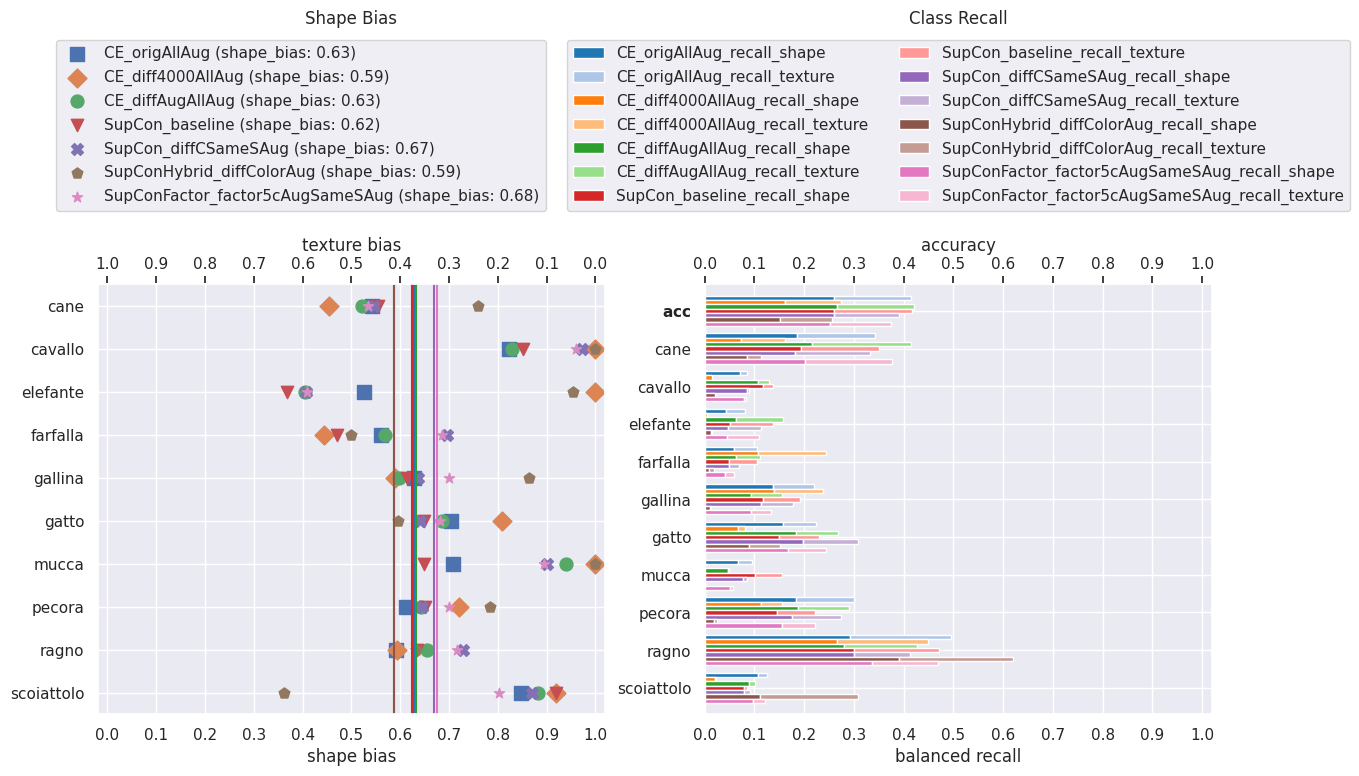

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
fig.tight_layout(w_pad=3)

ut_val.plot_shape_texture_conflict_bias(class_biasses, df_biases, ax=axs[0])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.4,1.15 + len(df_biases.columns)*0.0625))
ut_val.plot_class_recall_stacked(class_biasses, df_biases, ax=axs[1])

df_biases.sort_index()

In [32]:
entry = {"df_biases": df_biases}
for m in class_biasses:
    entry[m] = class_biasses[m]
with open("./save/Validation/cueConfShapeBias/colorAug_cueConfShapeBias", 'wb') as f:
    pickle.dump(entry, f, protocol=-1)

------------------

In [ ]:
model_short_name = "CE_baseline"

root_model = models_dict[model_short_name][0]
dataset_classifier = models_dict[model_short_name][1]

df_bias, df_class_bias = cue_conflict_shape_bias_metric(root_model, dataset_classifier, model_short_name, root_dataset_conflict, cuda_device)

df_bias

,CE_baseline
shape_bias,0.455158
shape_bias_b,0.419526
acc,0.538770
acc_b,0.507488
acc_shape,0.245225
acc_b_shape,0.212904
acc_texture,0.293545
acc_b_texture,0.294583


In [ ]:
df_class_bias

,cane,cavallo,elefante,farfalla,gallina,gatto,mucca,pecora,ragno,scoiattolo
shape_bias,0.711370,0.925000,0.079284,0.047030,0.461538,0.444444,0.538462,0.472362,0.626522,0.754902
shape_bias_b,0.548191,0.925132,0.141244,0.058985,0.413989,0.565331,0.627683,0.570465,0.451486,0.816383
recall,0.236226,0.114177,0.464923,0.421712,0.206897,0.225770,0.099781,0.220133,0.514266,0.112211
recall_b,0.228726,0.114269,0.379720,0.381654,0.210384,0.233026,0.104645,0.226343,0.531900,0.126772
recall_shape,0.250771,0.211429,0.107266,0.045024,0.174194,0.263473,0.131367,0.258242,0.480290,0.206989
recall_texture,0.206681,0.017110,0.652174,0.718284,0.246575,0.202578,0.077922,0.194444,0.583510,0.046555


### Correlation Coefficient Shape Bias

In [25]:
df_dims = corelation_coefficient_shape_bias_metric_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, use_colorJitter=True)
df_dims

100%|██████████| 202/202 [02:03<00:00,  1.63it/s]


,shape_dims,texture_dims,color_dims,remaining_dims
CE_origAllAug,133,102,104,173
CE_diff4000AllAug,133,106,90,183
CE_diffAugAllAug,155,94,96,167
SupCon_baseline,129,105,101,177
SupCon_diffCSameSAug,155,92,94,171
SupConHybrid_diffColorAug,162,88,90,172
SupConFactor_factor5cAugSameSAug,163,87,88,174


In [28]:
df_dims.to_csv("./save/Validation/corrCoefShapeBias/colorAug_corrCoefShapeBias.csv")

-------------------

In [53]:
df_dims = corelation_coefficient_shape_bias_metric_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, use_colorJitter=True)

100%|██████████| 202/202 [02:19<00:00,  1.44it/s]


In [54]:
# with colorJitter
df_dims

,shape_dims,texture_dims,color_dims,remaining_dims
CE_baseline,115,96,121,180
SupConFactor_factor5cAugSameSAug,163,87,88,174


In [45]:
# without colorJitter
df_dims

,shape_dims,texture_dims,color_dims,remaining_dims
CE_baseline,129,111,109,163
SupConFactor_factor5cAugSameSAug,165,87,86,174


### Feature Embedding Distances

In [26]:
df_distances = compute_distance_to_diff_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, plot_hist=False)
df_distances

100%|██████████| 5236/5236 [03:44<00:00, 23.37it/s]


,CE_origAllAug,CE_diff4000AllAug,CE_diffAugAllAug,SupCon_baseline,SupCon_diffCSameSAug,SupConHybrid_diffColorAug,SupConFactor_factor5cAugSameSAug
mean_distance_related,0.099117,0.139096,0.013839,0.226679,0.032401,0.001178,0.015663
std_distance_related,0.058820,0.099811,0.011410,0.116360,0.030118,0.002333,0.012129
mean_distance_classes,0.153077,0.201032,0.096321,0.368303,0.258689,0.329383,0.323084
std_distance_classes,0.068758,0.113216,0.052362,0.122202,0.108764,0.112243,0.121208
mean_distance_all_vs_all,0.231440,0.265197,0.212399,0.456118,0.376015,0.352992,0.417543
std_distance_all_vs_all,0.089758,0.113970,0.090066,0.108909,0.107598,0.107873,0.114314
min_distance,0.000988,0.001550,0.000581,0.002855,0.000947,0.000035,0.000419
max_distance,0.807780,0.883003,0.777430,0.950444,0.934392,0.886910,0.945144


---------------

In [30]:
df_distances.to_csv("./save/Validation/distances/colorAug_distances.csv")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 5236/5236 [00:35<00:00, 149.15it/s]


,CE_baseline
mean_distance_related,0.076772
std_distance_related,0.048060
mean_distance_classes,0.144753
std_distance_classes,0.067892
mean_distance_all_vs_all,0.238583
std_distance_all_vs_all,0.094017
min_distance,0.000970
max_distance,0.855252


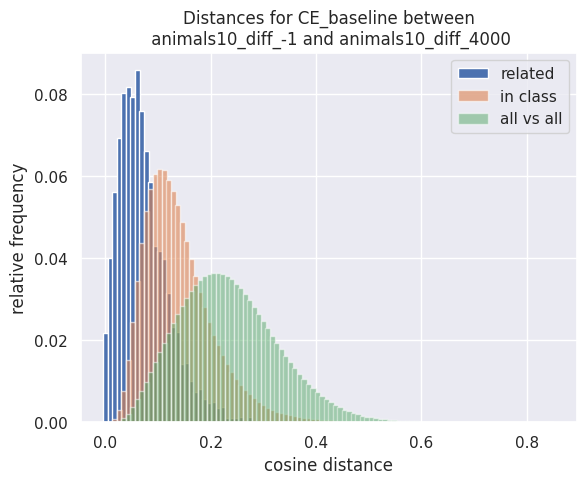

In [28]:
model_short_name = "CE_baseline"

root_model = models_dict[model_short_name][0]
df_dist = compute_distance_to_diff(root_model, model_short_name, dataset_orig, dataset_shape, cuda_device, plot_hist=True)
df_dist

100%|██████████| 5236/5236 [00:27<00:00, 188.10it/s]


,CE_baseline,SupConFactor_factor5cAugSameSAug
mean_distance_related,0.076772,0.015663
std_distance_related,0.048060,0.012129
mean_distance_classes,0.144753,0.323084
std_distance_classes,0.067892,0.121208
mean_distance_all_vs_all,0.238583,0.417543
std_distance_all_vs_all,0.094017,0.114314
min_distance,0.000970,0.000419
max_distance,0.855252,0.945144


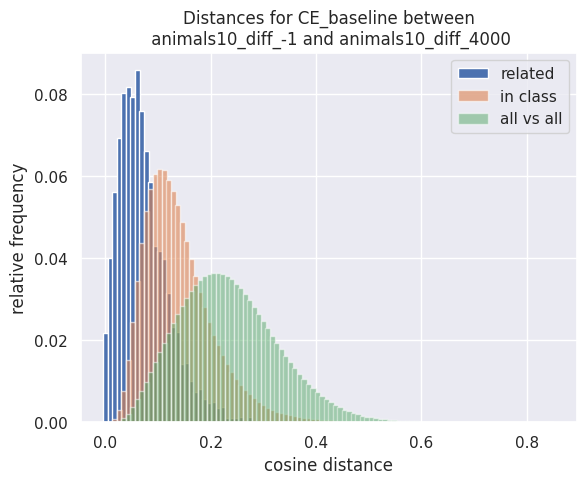

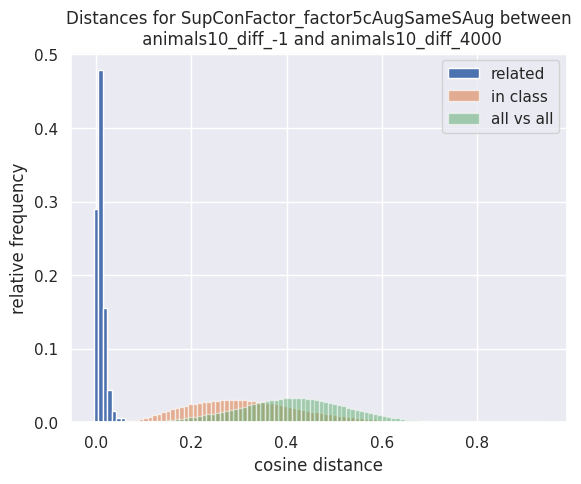

In [24]:
df_distances = compute_distance_to_diff_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, plot_hist=True)
df_distances